# Textual Analysis of XPN's AtoZ Playlist

One of the cool things about [WXPN](http://xpn.org)
is their frequent special programming which is always interesting.
This year, they put together a multi-day alphabetical playlist
called [XPN's A to Z](http://xpn.org/music-artist/xpn-a-z).
As has been the case for a lot of these events,
the [#XPNAtoZ](https://twitter.com/search?q=%23XPNAtoZ) tweet stream
is as interesting as the music.
Initially I was confused by why
Johnny Cash's _A Boy Named Sue_ was the 3rd song,
when I'd have filed it in the Bs.
So, after getting involved in a 
[twitter exchange](https://twitter.com/brianjgainor/status/803966913483329536)
on the topic of treating articles as significant,
an idea came to me.
I could look at the data to see how words that typically live on stop lists
skewed the distribution of the music.
Along the way other interesting explorations might turn up.
What follows is the result.

## Disclaimer

At present I must point out that this is all very preliminary

- As I write this, after almost 6 days, 
  the play list has just made it to the Is, so things will change over time.
- So far the analysis is pretty primitive.  That will improve over time.
- I'm avoiding spending too much time on improving presentation,
  especially in graphs, until the data stabilizes.

## Load the data

The [AtoZ Playlist page](http://xpn.org/music-artist/xpn-a-z)
contains a directory of songs by first letter.
Behind the scenes, it makes ReST request to their backend.
Eventually I should cache the results,
so this keeps working when they change the site.
But right now while the playlist is still going,
just build a data frame off of the results.

In [1]:
%matplotlib inline
from lxml import html
import requests
import pandas as pd
from IPython.display import display, HTML

rows = []
for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    page = requests.get('http://xpn.org/static/az.php?q=%s' %  letter)
    tree = html.fromstring(page.content)
    plays = tree.xpath('//li/text()')
    for play in plays:
        rows.append(play.split(' - ', 1))
playlist = pd.DataFrame(rows, columns=('Title', 'Artist'))

If we just look at some basic stats on the resulting DataFrame,
we see that things are potentially interesting.
Some titles appear multiple times
and Artists, especially the Beatles, repeat.
so there's potential for learning something from patterns and frequencies.

In [2]:
HTML(playlist.describe().to_html())

,Title,Artist
count,1943,1943
unique,1757,889
top,Crazy,The Beatles
freq,5,51


Just to get a feel for the data in general,
here's the first 10 rows of the data set.
Basically it's two columns: title and artist.
And since the data is pretty straight forward,
I'm not doing much to clean it up.

In [3]:
HTML(playlist.head(10).to_html())

,Title,Artist
0,ABC,Jackson 5
1,A Big Hunk O' Love,Elvis Presley
2,A Boy Named Sue (live),Johnny Cash
3,A Case Of You,Joni Mitchell
4,A Certain Girl,Ernie K-Doe
5,A Certain Girl,Warren Zevon
6,A Change,Sheryl Crow
7,A Change Is Gonna Come,Sam Cooke
8,A Day In The Life,The Beatles
9,A Day In The Life,The Beatles


## Data Analysis

### Songs by Letter

It's the simplest thing one can look at.
And I wouldn't think it all that interesting.
But given how long A, B, C took
and the rate at which we're steaming though E,
it might be worth looking at.

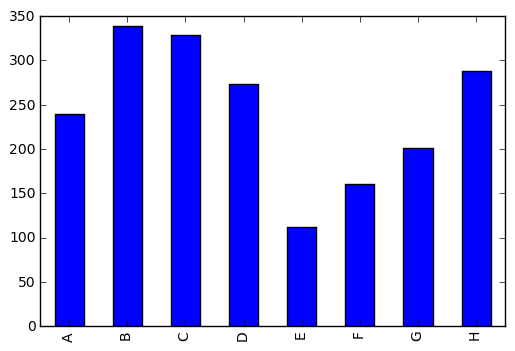

In [4]:
playlist.apply(lambda x: x[0][0], axis=1).value_counts().sort_index().plot(kind='bar')

### Most Frequent Artists

Even this early in the playlist,
some artists show up often.
This might say something about the music the station plays,
or the listeners as much of this list comes from previous 
playlists like "885 best songs of all time"
or my favorite, the "85 worst songs of all time."
For the moment, let's just look at the most frequent dozen or so.

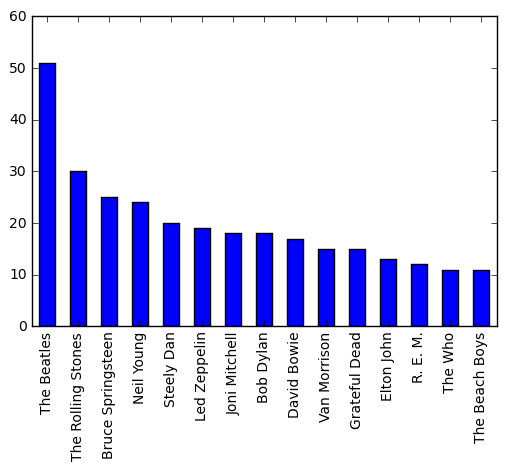

In [5]:
playlist['Artist'].value_counts().head(15).plot(kind='bar')


### Duplicate Titles

From the titles alone, covers and songs that just happen to have the same title
look the same.
But even a few letters in, the number of duplicate titles
is more than I'd have expected.
And a few are more than just duplicated.
In fact, it's crazy that there were five songs called "Crazy"
and that's only tied for first place.

In [6]:
title_counts = playlist['Title'].value_counts().to_frame('count')
HTML(title_counts[title_counts['count'] > 2].to_html())

,count
Crazy,5
Home,5
Dreams,5
Hold On,5
Human,4
Ball Of Confusion,4
Fire,4
Hard to Handle,4
Fever,4
Cocaine,3


### Most Frequent First Words

This is the question that started me down this path.
How much do common "stop words" like articles or propositions 
skew the distribution?
Or do so many songs start with a small set of words
that no amount of pruning would even the distribution out?
Here's an early look a the top 15 first words.
Yes, "A" is up there.
But it's not first, even early on.
And there are a number of repeating leading words.
So perhaps my initial concerns were unfounded.

Note that finding the first word is harder than it might seem.
For way more detail than a normal human would want,
see the [Word Splitting](Word Splitting.ipynb) notebook.
Short version, any sequence of letters or apostrophes is a word
for our purposes.

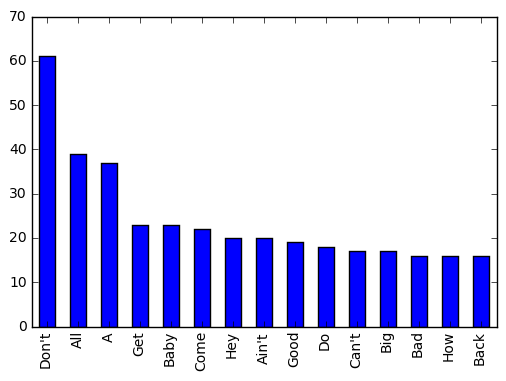

In [7]:
from nltk.tokenize import RegexpTokenizer
custom_tokenize = RegexpTokenizer("[\w'\-]+|[^\w'\s\-]").tokenize

playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1).value_counts().head(15).plot(kind='bar')

The same data as a word cloud,
though the python wordcloud package does a few things work against us
and are not customizable in the released version.

<function matplotlib.pyplot.show>

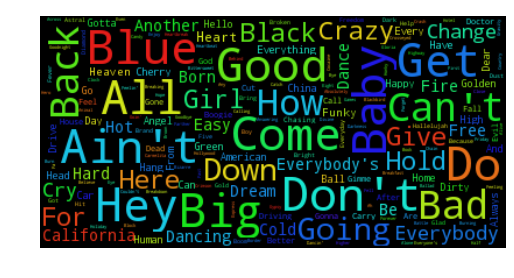

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

firsts = playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1)
wordcloud = WordCloud(max_font_size=40, stopwords='').generate(' '.join(firsts.tolist()))
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show


## Availability

The code for this project is in [my git hub repo](https://github.com/asudell/a2z).
The notebook its self is [published on nbviewer](http://nbviewer.jupyter.org/github/asudell/a2z/blob/master/AtoZ.ipynb)

## License

This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.